# Bioesa - raport

Notebook z przykładowym użyciem biblioteki bioesa, służacej do analizy sygnałów bioelektrycznych w formacie .raw. 

Bibliotekę pobrałam lokalnie używając komendy "pip3 install ."

In [1]:
import bioesa
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# lokalizacja danych
data_path_ecg = '.\data\ecg_data'
data_path_eeg = '.\data\eeg_data'
data_path_emg = '.\data\emg_data'

## Analiza sygnału EKG

Każdy sygnał przed analizą musi być poddany preprocessingowi. W przypadku sygnałów bioelektrycznych niezbędne jest załadowanie sygnałów w poprawnym formacie oraz zastosowanie filtrów (notch oraz jakiegoś pasmoprzepustowego).

Będę jednocześnie pracować na 2 sygnałach EKG żeby pokazać różnice między sygnałem elektrycznym serca w stanie spoczynku i po wysiłku fizycznym.

In [3]:
from bioesa.preprocessing import load_signal, filter_signal

In [4]:
# wczytywanie sygnałów i metadanych

ekg_rest, *params1, = load_signal(os.path.join(data_path_ecg, 'ecg-rest.raw'), F_samp=128, n_channel=3)
ekg_run, *params2, = load_signal(os.path.join(data_path_ecg, 'ecg-run.raw'), F_samp=128, n_channel=3)
    

if len(params1) == 3:
    F_samp = params1[0]
    channel_names = params1[1]
    tags = params1[2]
else:
    F_samp1 = params1[0]
    F_samp2 = params2[0]


print(F_samp1, F_samp2)
    
print(np.shape(ekg_rest))
print(np.shape(ekg_run))

128 128
(3, 46084)
(3, 27092)


In [5]:
# filtrowanie sygnalów 

filt_syg_rest = filter_signal(ekg_rest, F_samp1, butter_band=[1, 40])
filt_syg_run = filter_signal(ekg_run, F_samp2, butter_band=[1, 40])

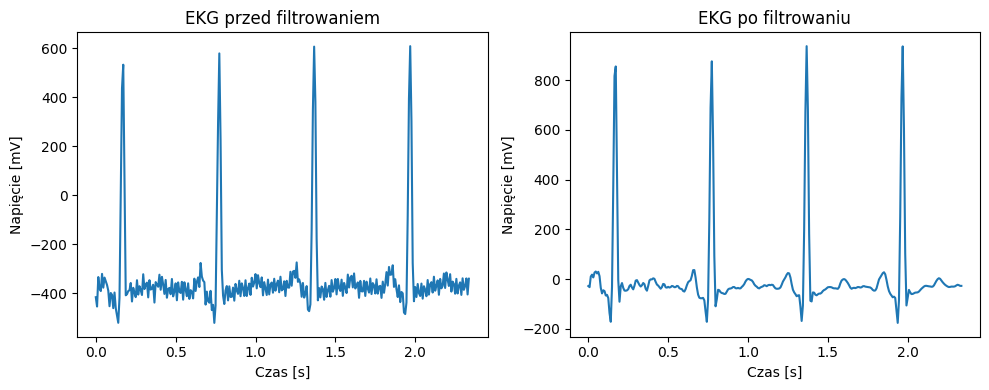

In [6]:
T1 = len(filt_syg_rest[0])/F_samp1
t1 = np.arange(0, T1, 1/F_samp1)

fig = plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(t1[0:300], ekg_rest[2][0:300])
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [mV]')
plt.title('EKG przed filtrowaniem')

plt.subplot(1, 2, 2)
plt.plot(t1[0:300], filt_syg_rest[2][0:300])
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [mV]')
plt.title('EKG po filtrowaniu')

plt.tight_layout()
plt.show()

Kolejnym ważnym elementem analizy sygnału jest odpowiedni montaż sygnału; każdy rodzaj sygnału ma swój charakterystyczny sposób montażu.

In [7]:
from bioesa.ecg_analysis import einthoven_montage

mont_rest = einthoven_montage(filt_syg_rest)
mont_run = einthoven_montage(filt_syg_run)

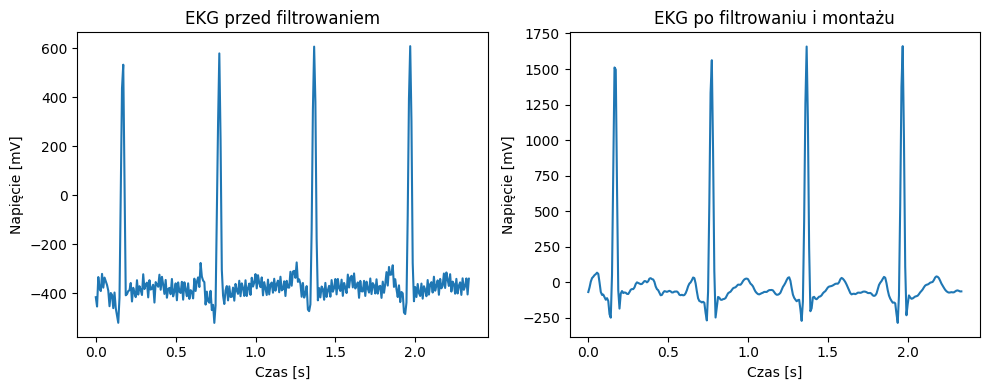

In [8]:
fig = plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(t1[0:300], ekg_rest[2][0:300])
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [mV]')
plt.title('EKG przed filtrowaniem')

plt.subplot(1, 2, 2)
plt.plot(t1[0:300], mont_rest[2][0:300])
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [mV]')
plt.title('EKG po filtrowaniu i montażu')

plt.tight_layout()
plt.show()

Z sygnału EKG możemy odczytać nasze tętno:

In [9]:
from bioesa.ecg_analysis import find_heart_rate

# w spoczynku
print('Tętno w spoczynku:')
HR_rest = find_heart_rate(mont_rest[2], F_samp1)

# po wysiłku 
print('Tętno po wysiłku:')
HR_run = find_heart_rate(mont_run[2], F_samp2)

Tętno w spoczynku:
Mean heart rate value in the respective minutes:  [ 97. 102.  98.  97.  94.  96.]
Mean heart value:  97.33
Tętno po wysiłku:
Mean heart rate value in the respective minutes:  [132. 128. 128.]
Mean heart value:  129.33


Możemy też wyznaczyć przebieg HRV

In [10]:
from bioesa.ecg_analysis import find_hrv, hrv_plot

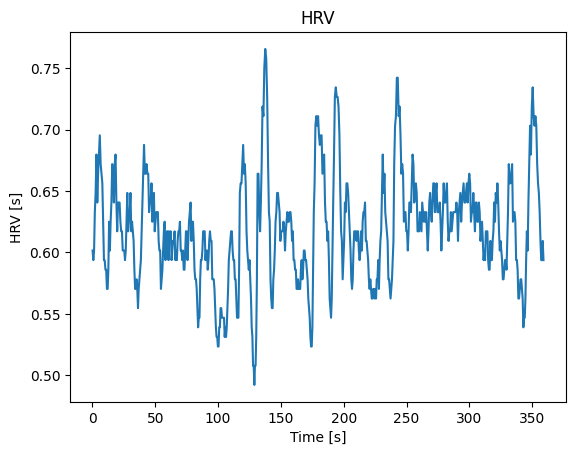

In [11]:
HRV1, t1 = find_hrv(mont_rest[1], F_samp1)
hrv_plot(HRV1, t1)

## Analiza EMG

Pierwsze kroki analizy sygnału elektrycznego mięśni wyglądają podobnie, jak dla EKG

In [12]:
# wczytywanie sygnałów i metadanych

emg, *params, = load_signal(os.path.join(data_path_emg, 'emg.raw'), F_samp=2048, n_channel=5)

if len(params) == 3:
    F_samp = params[0]
    channel_names = params[1]
    tags = params[2]
else:
    F_samp = params[0]

print(F_samp)
    
print(np.shape(emg))


2048
(5, 755456)


In [13]:
# filtrowanie sygnalów 

filt_emg = filter_signal(emg, F_samp, butter_band=[20, 400])

In [14]:
# montaż sygnału 
from bioesa.emg_analysis import emg_montage

mont_emg = emg_montage(filt_emg)

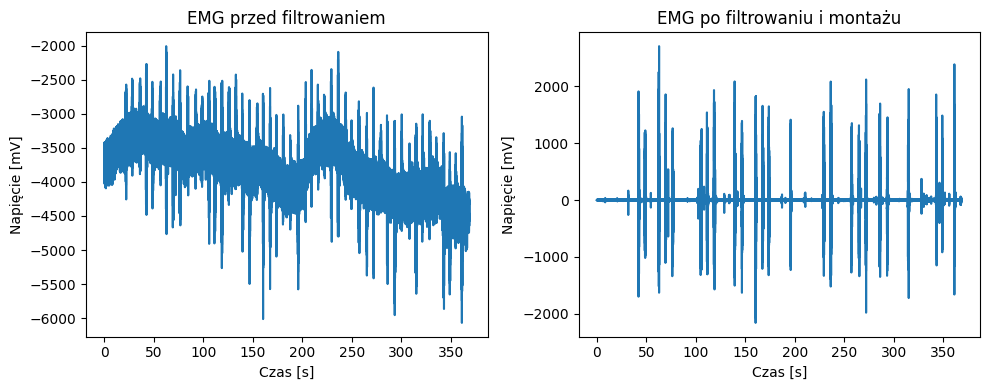

In [15]:
T = len(filt_emg[0])/F_samp
t = np.arange(0, T, 1/F_samp)

fig = plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(t, emg[0])
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [mV]')
plt.title('EMG przed filtrowaniem')

plt.subplot(1, 2, 2)
plt.plot(t, mont_emg[0])
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [mV]')
plt.title('EMG po filtrowaniu i montażu')

plt.tight_layout()
plt.show()

Jednym z podstawowych metod analizy sygnału jest analiza częstotliwościowa. W tej paczce wykorzystałam metodę Welcha do obliczania widma mocy sygnału.

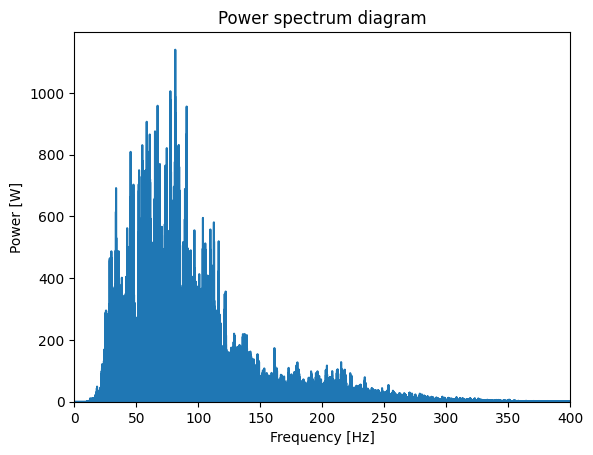

In [16]:
from bioesa.preprocessing import find_spectrum, plot_spectrum

f, P = find_spectrum(mont_emg[0], F_samp)
plot_spectrum(f, P, [0, 400])

## Analiza EEG

### Sygnał alfa

Najciekawszym do analizowaniem jest sygnał elektryczny z mózgu

In [17]:
# wczytywanie sygnałów i metadanych

eeg, *params, = load_signal(os.path.join(data_path_eeg, 'eeg_alfa.raw'),
                            os.path.join(data_path_eeg, 'eeg_alfa.xml'),
                            os.path.join(data_path_eeg, 'eeg_alfa.tag'))

if len(params) == 3:
    F_samp = params[0]
    channel_names = params[1]
    tags = params[2]
else:
    F_samp = params[0]

print(F_samp)
    
print(np.shape(eeg))


2023-02-08 05:42:22,695 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


512.0
(25, 153888)


In [18]:
from bioesa.eeg_analysis import eeg_montage

eeg_mont = eeg_montage(eeg)

In [19]:
eeg_filt = filter_signal(eeg_mont, F_samp, [1,40])

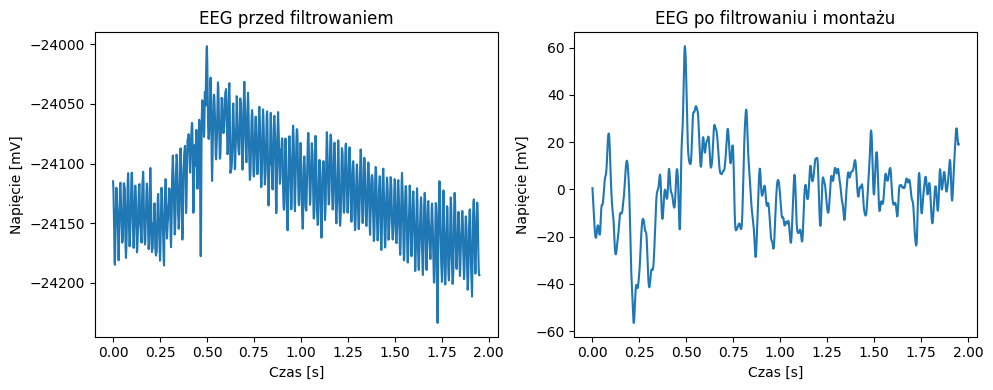

In [20]:
T = len(eeg_filt[0])/F_samp
t = np.arange(0, T, 1/F_samp)

fig = plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(t[0:1000], eeg[0][0:1000])
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [mV]')
plt.title('EEG przed filtrowaniem')

plt.subplot(1, 2, 2)
plt.plot(t[0:1000], eeg_filt[0][0:1000])
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [mV]')
plt.title('EEG po filtrowaniu i montażu')

plt.tight_layout()
plt.show()

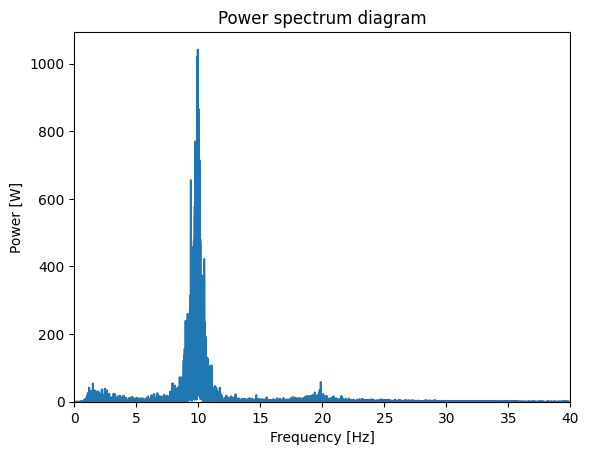

In [21]:
f, P = find_spectrum(eeg_filt[17], F_samp)
plot_spectrum(f, P, [0, 40])

Na spektogramie bardzo wybija się częstotliwość 10 Hz, ktora jest częstościa charakterystyczną dla rytmu alfa w EEG.

# Uśrednianie sygnałów i widm po tagach

Wczytuje drugi sygnał analogicznie do poprzednich, tym razem będę też pracować z tagami

In [26]:
# wczytywanie sygnałów i metadanych

eeg_ep, *params, = load_signal(os.path.join(data_path_eeg, 'eeg_evoked.raw'),
                            os.path.join(data_path_eeg, 'eeg_evoked.xml'),
                            os.path.join(data_path_eeg, 'eeg_evoked.tag'))

if len(params) == 3:
    F_samp = params[0]
    channel_names = params[1]
    tags = params[2]
else:
    F_samp = params[0]

print(F_samp)
print(np.shape(eeg_ep))

eeg_ep_mont = eeg_montage(eeg_ep)
eeg_ep_filt = filter_signal(eeg_ep_mont, F_samp, [1,40])

2023-02-08 05:46:03,080 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


512.0
(21, 711968)


Tak przygotowany sygnał dzielimy według tagów, które dzielą sygnał na 4 podzbiory krótkich zapisów powiązanych z bodźcem w czasie eksperymentu. Każdy z podzbioró uśredniamy - otrzymujemy tak metodę potencjałów wywołanych.

In [33]:
from bioesa.eeg_analysis import evoked_potentials

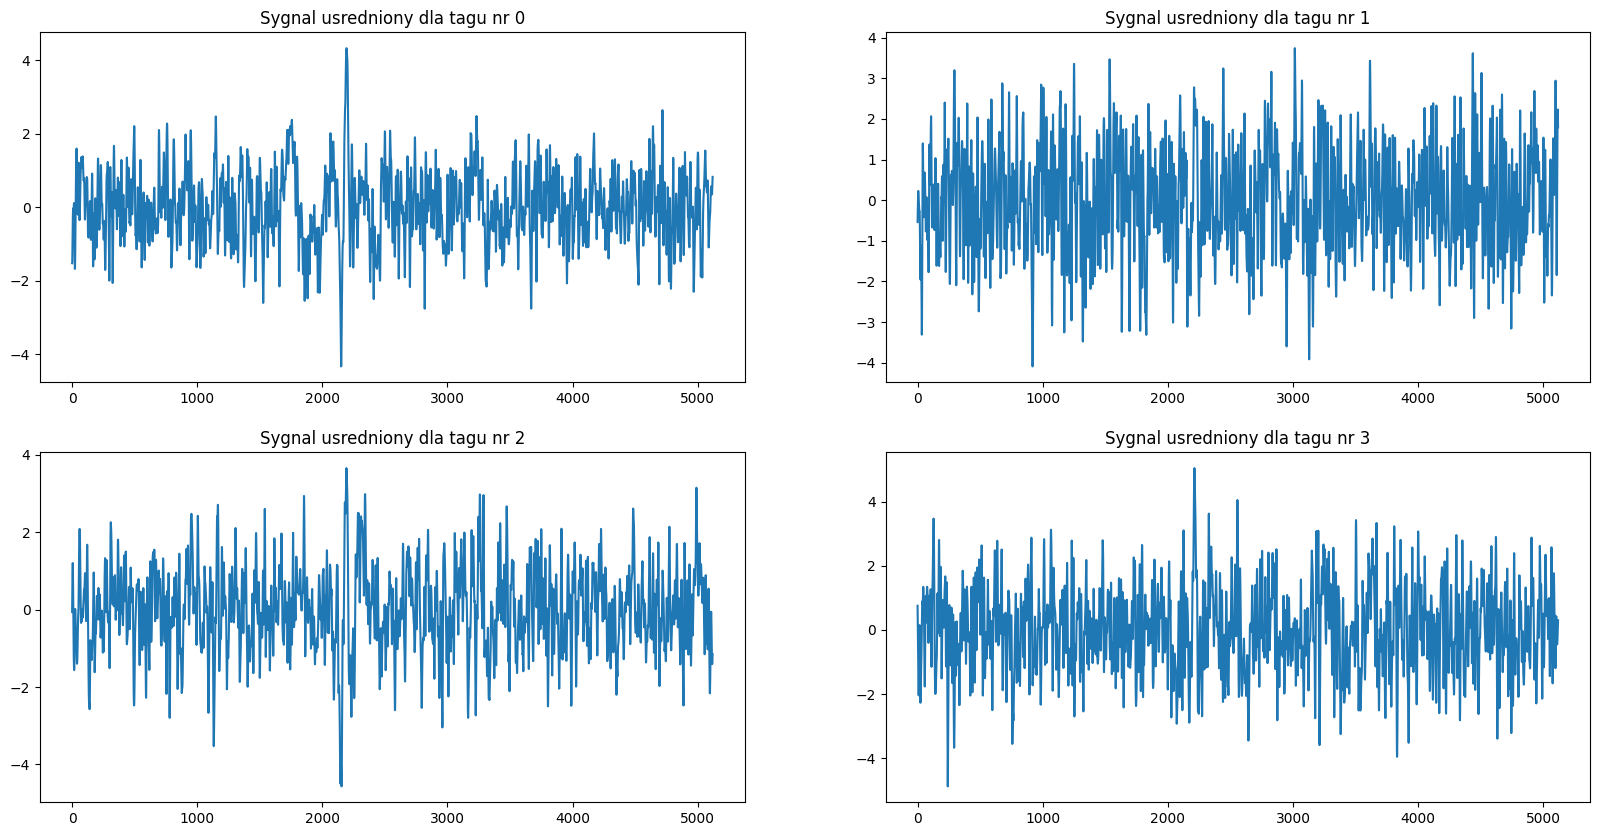

In [34]:
eps = evoked_potentials(eeg_ep_filt[17], tags, F_samp)

fig = plt.figure(figsize=(20,10))
for i in range(np.shape(eps)[0]):
    plt.subplot(2,2,i+1)
    plt.plot(eps[i])
    plt.title(f'Sygnal usredniony dla tagu nr {i}')

plt.tight_layout
plt.show()


Dla każdego uśrednionego według tagu sygnału wykonuję widmo:


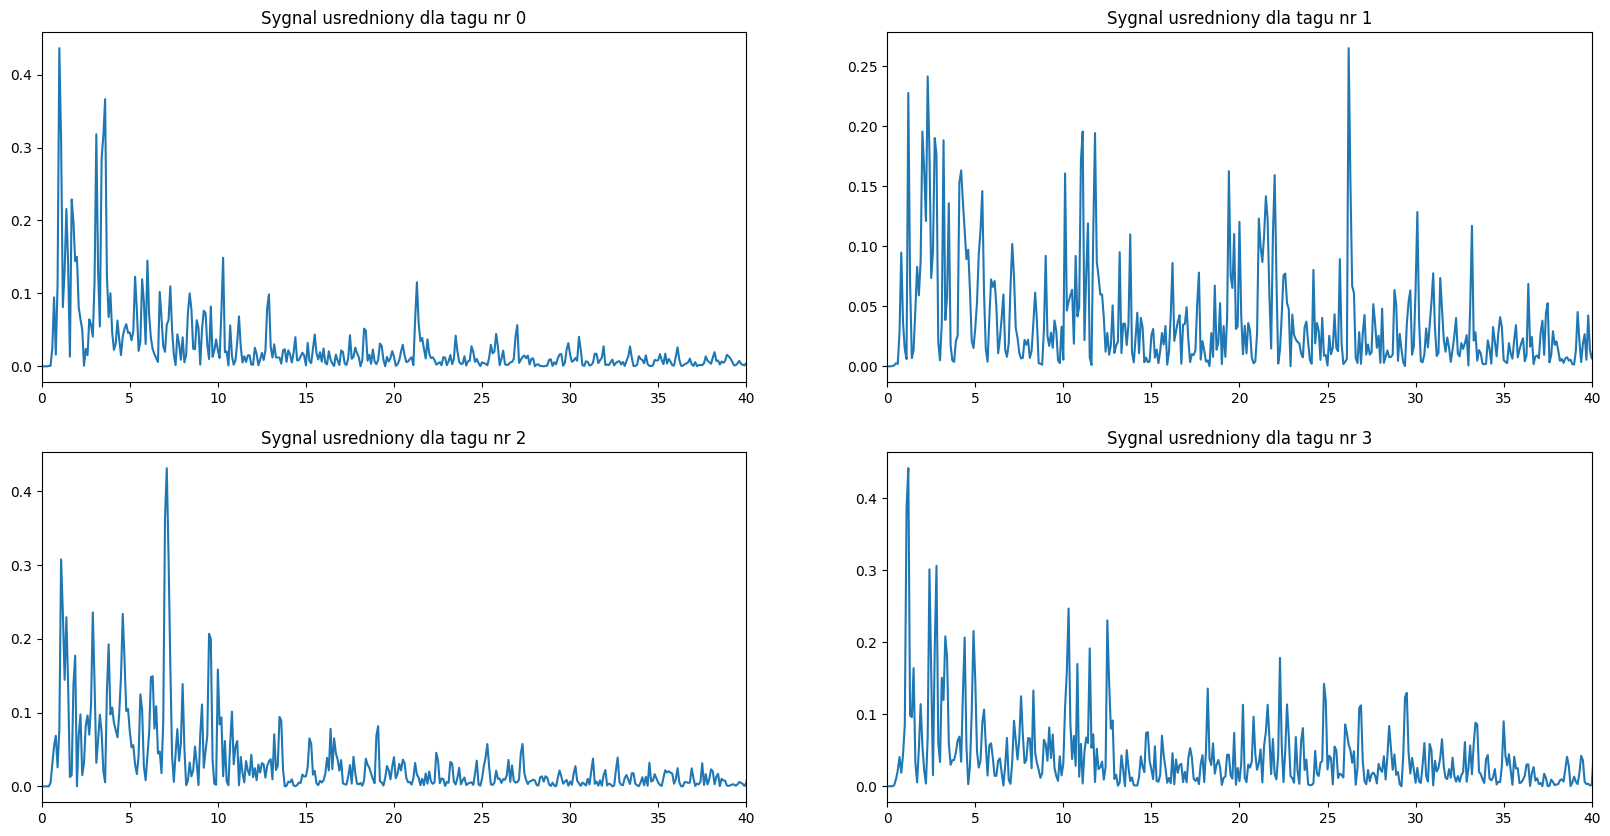

In [35]:
fig = plt.figure(figsize=(20,10))
for i in range(np.shape(eps)[0]):
    plt.subplot(2,2,i+1)
    plt.plot(*find_spectrum(eps[i], F_samp))
    plt.xlim([0,40])
    plt.title(f'Sygnal usredniony dla tagu nr {i}')

plt.tight_layout
plt.show()

Tagi 1 oraz 3 były związane z poleceniami ruchu ręką, co bardzo zaburza pomiar sygnału EEG. Podczas tagów 0 i 2 osoba badana jedynie wyobrażała sobie ruch, stąd widmo jest mniej bogate